In [1]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q langchain
!pip install -q einops
!pip install -q -U wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.5.2 requires huggingface-hub==0.13.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch

import transformers
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import TrainingArguments

from peft import LoraConfig

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from langchain.prompts import PromptTemplate

from IPython.display import Markdown, display

In [4]:
data = load_dataset("csv", data_files="../input/kaggle-llm-science-exam/train.csv")
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/seshu/.cache/huggingface/datasets/csv/default-dbedbb0a6f169693/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/Users/seshu/miniconda3/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
        num_rows: 200
    })
})

In [5]:
def plot_sequence_lengths(data, split='train', max_length=2048):
    sequence_lengths = []
    keep_indices = []

    # Loop over the dataset and get the lengths of text sequences
    for i, example in enumerate(data[split]):
        sequence_lengths.append(len(example['text']))
        if sequence_lengths[i] < max_length:
            keep_indices.append(i)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return keep_indices

In [7]:
template = """Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: {prompt}\n
A) {a}\n
B) {b}\n
C) {c}\n
D) {d}\n
E) {e}\n

Answer: {answer}"""

prompt = PromptTemplate(template=template, input_variables=['prompt', 'a', 'b', 'c', 'd', 'e', 'answer'])

In [8]:
sample = data['train'][0]
display(Markdown(prompt.format(prompt=sample['prompt'], 
                               a=sample['A'], 
                               b=sample['B'], 
                               c=sample['C'], 
                               d=sample['D'], 
                               e=sample['E'], 
                               answer=sample['answer'])))

Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?

A) MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."

B) MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.

C) MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.

D) MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.

E) MOND is a theory that eliminates the observed missing baryonic mass in galaxy clusters by imposing a new mathematical formulation of gravity that does not require the existence of dark matter.


Answer: D

In [9]:
def format_text(example):
    text = prompt.format(prompt=example['prompt'], 
                         a=example['A'], 
                         b=example['B'], 
                         c=example['C'], 
                         d=example['D'], 
                         e=example['E'], 
                         answer=example['answer'])
    return {"text": text}


In [10]:
data = data.map(format_text)
data

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'text'],
        num_rows: 200
    })
})

In [11]:
def plot_sequence_lengths(data, split='train', max_length=2048):
    sequence_lengths = []
    keep_indices = []

    # Loop over the dataset and get the lengths of text sequences
    for i, example in enumerate(data[split]):
        sequence_lengths.append(len(example['text']))
        if sequence_lengths[i] < max_length:
            keep_indices.append(i)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return keep_indices

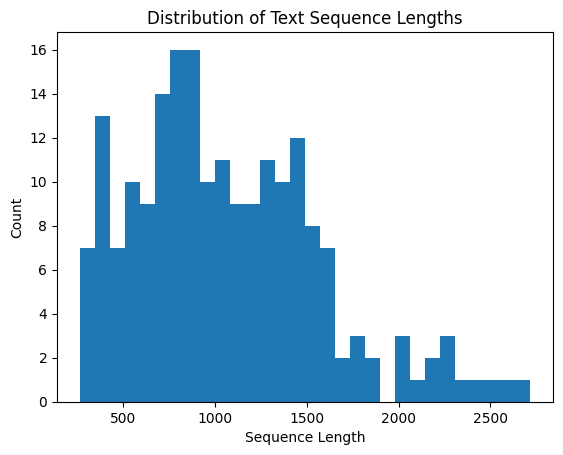

In [12]:
keep_indices_train = plot_sequence_lengths(data)

In [13]:
data['train'] = data['train'].select(keep_indices_train)

In [14]:
model_id = "tiiuae/falcon-7b"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [16]:
qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [17]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    trust_remote_code=True,
    revision="2f5c3cd4eace6be6c0f12981f377fb35e5bf6ee5" # Using this version because running the new version gives error 
)

RuntimeError: No GPU found. A GPU is needed for quantization.